In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from data.image import CS_Images
from data.config import BRAIN_VISA_PATH, CS_CORRECTED
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

import SimpleITK as sitk

from skimage import measure

import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Loading and plotting data

In [2]:
cs_paths = [x for x in Path(BRAIN_VISA_PATH).glob(CS_CORRECTED)]
dataset = CS_Images(segmentation='all',
                    mesh=True,
                    preload=False)

Found 308 subjects and 308 MPRAGE images
Found 13 subjects with both BrainVisa and corrected from 308 subjects


In [3]:
dataset.get_caseidx('sub-via248')

(array([0]),)

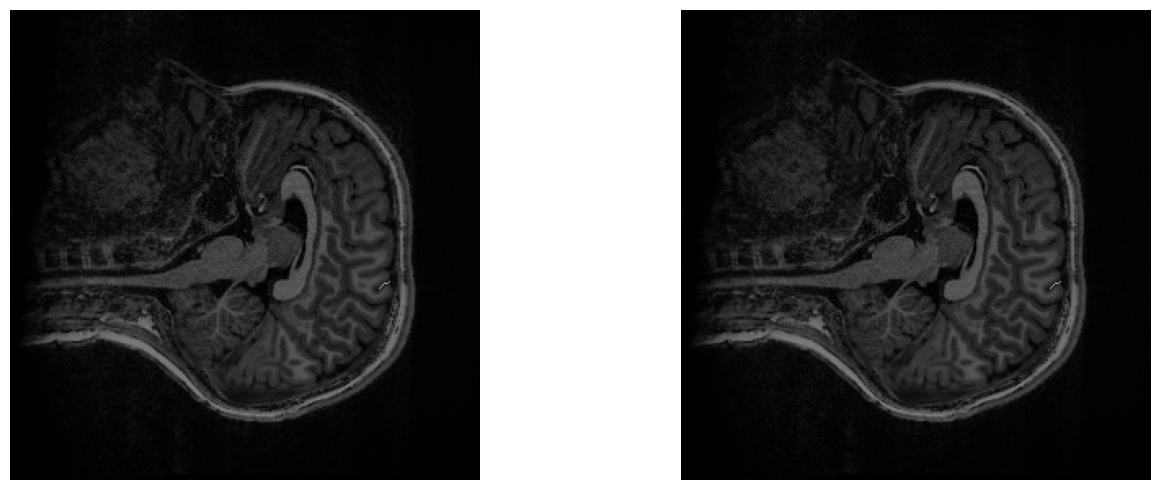

In [4]:
s0 = dataset[2]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']
slc = 100

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :].T, cmap='gray')
axs[0].imshow(bvisa[slc, :, :].T, alpha=0.5, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(img[slc, :, :].T, cmap='gray')
axs[1].imshow(corrected[slc, :, :].T, alpha=0.5, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [6]:
def touint8(img):
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

In [7]:
def img_mask_overlay(img, mask):
    mask = np.stack([mask, mask, mask], axis=-1).astype(np.bool_)
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    img[mask] = 255
    axs.imshow(img)
    axs.set_axis_off()
    plt.show()

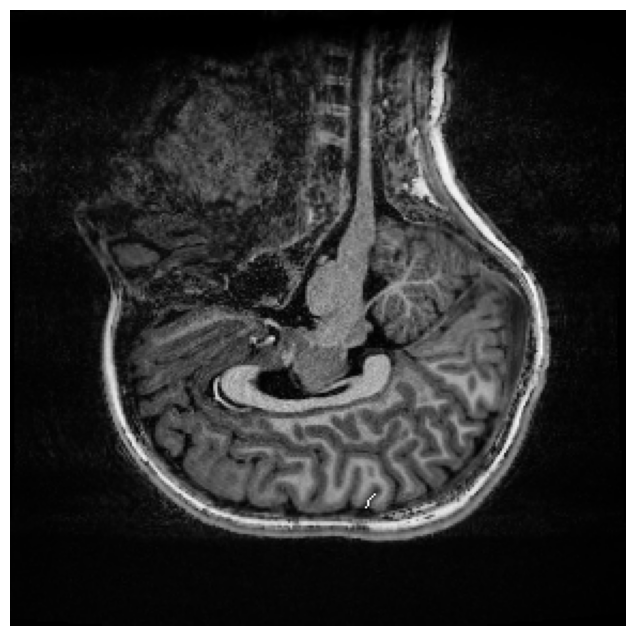

In [8]:
img_rgb = touint8(img[slc, :, :]) # np.stack([img[slc, :, :].T] * 3, axis=-1)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
mask = bvisa[slc, :, :]
img_mask_overlay(img_rgb, mask)

In [9]:
bvisa_pcd = np.stack((bvisa==1).nonzero()).T
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(bvisa_pcd[:,:3])
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd],)


In [10]:
vgrd = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, 1)
o3d.visualization.draw_geometries([vgrd],
                                  mesh_show_wireframe=True,
                                  mesh_show_back_face=False,
                                  point_show_normal=True)

In [11]:
o3d.visualization.draw_geometries([s0['bvisa_mesh_lscl'],
                                   s0['bvisa_mesh_rscl']],
                                  mesh_show_wireframe=True,
                                  mesh_show_back_face=True)


[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

In [8]:
# We create a visualizer object that will contain references to the created window, the 3D objects and will listen to callbacks for key presses, animations, etc.
vis = o3d.visualization.Visualizer()
# New window, where we can set the name, the width and height, as well as the position on the screen
vis.create_window(window_name='CS Visualize', width=800, height=600)

# We call add_geometry to add a mesh or point cloud to the visualizer
s0['bvisa_mesh_lscl'].compute_vertex_normals()
# s0['bvisa_mesh_rscl'].compute_vertex_normals()
vis.add_geometry(s0['bvisa_mesh_lscl'])
# vis.add_geometry(s0['bvisa_mesh_rscl'])


# We run the visualizater
vis.run()
# Once the visualizer is closed destroy the window and clean up
vis.destroy_window()

In [23]:
mesh_in = o3d.geometry.TriangleMesh(s0['bvisa_mesh_lscl'])
o3d.visualization.draw_geometries([mesh_in])

print('filter with average with 1 iteration')
mesh_out = mesh_in.filter_smooth_simple(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

print('filter with average with 5 iterations')
mesh_out = mesh_in.filter_smooth_simple(number_of_iterations=100)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])
# mesh_out.compute_vertex_normals()

filter with average with 1 iteration
filter with average with 5 iterations


In [14]:
mesh_out = o3d.t.geometry.TriangleMesh.from_legacy(mesh_out)
# mesh_out.estimate_normals()
filled_mesh = mesh_out.fill_holes()
# o3d.visualization.draw_geometries([filled_mesh.to_legacy()])
filled_mesh

[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'


TriangleMesh on CPU:0 [2534 vertices (Float32) and 5068 triangles (Int64)].
Vertex Attributes: normals (dtype = Float32, shape = {2534, 3}).
Triangle Attributes: None.

In [11]:
sphere = o3d.geometry.TriangleMesh.create_sphere(1.0)
sphere = o3d.t.geometry.TriangleMesh.from_legacy(sphere)
clipped = sphere.clip_plane([0.8, 0, 0], [1, 0, 0])

o3d.visualization.draw_geometries([clipped.to_legacy()])

filled = clipped.fill_holes()
o3d.visualization.draw_geometries([filled.to_legacy()])


# Calculating comparison features

## Holes and volume-area statistics

In [9]:
clust_idx, triangl_per_clust, srf_are_per_clust = s0['bvisa_mesh_lscl'].cluster_connected_triangles()
print(f'Found {len(triangl_per_clust)} clusters with {triangl_per_clust} triangles and {srf_are_per_clust} surface area')

Found 1 clusters with [5068] triangles and DoubleVector[3706.49] surface area


In [10]:
srf_area = np.sum(srf_are_per_clust)
volume = s0['bvisa_mesh_lscl'].get_volume()
print(s0['bvisa_mesh_lscl'].is_self_intersecting())
print(s0['bvisa_mesh_lscl'].is_watertight())


False
True


In [54]:
import trimesh
import pymeshfix

In [39]:
np.asarray(s0['bvisa_mesh_lscl'].triangles)

array([[   0, 1522, 1523],
       [   0, 1523,    1],
       [   0,    1,  340],
       ...,
       [ 927, 2528, 2527],
       [ 927, 2532,  929],
       [1510, 2533, 2532]], dtype=int32)

In [40]:
np.asarray(s0['bvisa_mesh_lscl'].vertices)

array([[103.09963226, 153.03022766,  48.92225266],
       [101.64877319, 153.72068787,  48.90235138],
       [102.81158447, 153.22976685,  49.68653107],
       ...,
       [145.605896  , 122.98443604, 100.54023743],
       [145.67419434, 124.07154083, 101.27624512],
       [146.50094604, 123.66139984, 101.64936066]])

In [49]:
trimesh_mesh = trimesh.Trimesh(vertices=np.asarray(s0['bvisa_mesh_lscl'].vertices),
                               faces=np.asarray(s0['bvisa_mesh_lscl'].triangles))
print(trimesh_mesh.volume)
trimesh.repair.fill_holes(trimesh_mesh)
print(trimesh_mesh.volume)


1332.9548182286962
1332.9548182286962


In [85]:
from pymeshfix import _meshfix
import pyvista as pv

tin = _meshfix.PyTMesh()

tin.load_array(v=np.asarray(s0['bvisa_mesh_lscl'].vertices),
               f=np.asarray(s0['bvisa_mesh_lscl'].triangles))

print('There are {:d} boundaries'.format(tin.boundaries()))




INFO- Loaded 2534 vertices and 5068 faces.
There are 0 boundaries


In [86]:
tin.fill_small_boundaries(nbe=0, refine=False)


0% done 


0

In [65]:
# Fills all the holes having at at most 'nbe' boundary edges. If
# 'refine' is true, adds inner vertices to reproduce the sampling
# density of the surroundings. Returns number of holes patched.  If
# 'nbe' is 0 (default), all the holes are patched.
holes = tin.fill_small_boundaries(nbe=100, refine=True)


0% done 


In [50]:
mesh = o3d.t.geometry.TriangleMesh.from_legacy(s0['bvisa_mesh_lscl'])
volume = s0['bvisa_mesh_lscl'].get_volume()
filled = mesh.fill_holes(hole_size=0.001)
filled_volume = filled.to_legacy().get_volume()
print(f'Filled volume: {filled_volume} vs original volume: {volume}')

[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
Filled volume: 1332.954818228728 vs original volume: 1332.9548182287263


In [51]:
# We create a visualizer object that will contain references to the created window, the 3D objects and will listen to callbacks for key presses, animations, etc.
vis = o3d.visualization.Visualizer()
# New window, where we can set the name, the width and height, as well as the position on the screen
vis.create_window(window_name='CS Visualize', width=800, height=600)

# We call add_geometry to add a mesh or point cloud to the visualizer
s0['bvisa_mesh_lscl'].compute_vertex_normals()
# s0['bvisa_mesh_rscl'].compute_vertex_normals()
vis.add_geometry(filled.to_legacy())
# vis.add_geometry(s0['bvisa_mesh_rscl'])


# We run the visualizater
vis.run()
# Once the visualizer is closed destroy the window and clean up
vis.destroy_window()

## Branching statistics

In [21]:
s0 = dataset[1]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']


diff_image = bvisa != corrected

3

In [41]:
labels = measure.label(bvisa,
                       connectivity=2,
                       background=0)

In [42]:
np.unique(labels)

array([0, 1, 2, 3])

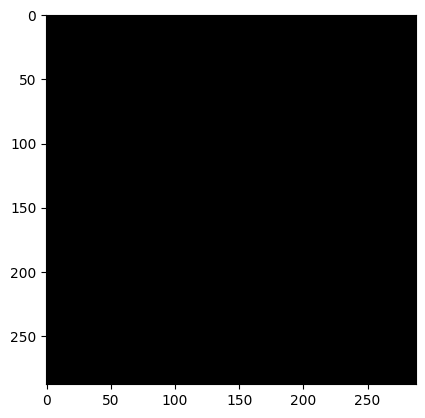

In [20]:
plt.imshow(diff_image[slc, :, :].T, cmap='gray')

In [19]:
from tqdm import tqdm
from data.mesh import MeshAnalyzer

In [20]:
a = s0['bvisa_mesh_lscl']

In [27]:
mesh_analyzer = MeshAnalyzer(['mesh_properties',
                              'cluster_properties',
                              'holes_filled_volume'])
mesh_analyzer.process(a)

[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'


{'is_self_intersecting': False,
 'is_watertight': True,
 'is_edge_manifold': True,
 'is_vertex_manifold': True,
 'cluster_connected_triangles': 4948,
 'triangl_per_clust': [4948],
 'srf_are_per_clust': DoubleVector[3623.36],
 'total_srf_area': 3623.359676571132,
 'total_volume': 1312.6516921477614,
 'filled_volume': 1312.651692147765}

## Load the analysis results

In [10]:
import pandas as pd

In [16]:
corrected_res.bvisaR_total_volume - corrected_res.bvisaR_holes_filled_volume

0     3.183231e-12
1    -3.183231e-12
2    -2.273737e-13
3     0.000000e+00
4    -1.364242e-12
5    -2.728484e-12
6    -2.728484e-12
7    -1.818989e-12
8    -3.865352e-12
9    -9.094947e-13
10   -1.591616e-12
11    0.000000e+00
12    2.728484e-12
dtype: float64

In [22]:
corrected_res['bvolume_diff'] = corrected_res.bvisaL_total_volume - corrected_res.bvisaL_holes_filled_volume

In [15]:
corrected_res = pd.read_csv('/mrhome/vladyslavz/git/central-sulcus-analysis/results/CS_shape_analysis_corrected.csv')
corrected_res.columns

Index(['caseid', 'centre', 'bvisaL_cluster_connected_triangles',
       'bvisaL_triangl_per_clust', 'bvisaL_srf_are_per_clust',
       'bvisaL_total_srf_area', 'bvisaL_is_self_intersecting',
       'bvisaL_is_watertight', 'bvisaL_is_edge_manifold',
       'bvisaL_is_vertex_manifold', 'bvisaL_total_volume',
       'bvisaL_holes_filled_volume', 'bvisaR_cluster_connected_triangles',
       'bvisaR_triangl_per_clust', 'bvisaR_srf_are_per_clust',
       'bvisaR_total_srf_area', 'bvisaR_is_self_intersecting',
       'bvisaR_is_watertight', 'bvisaR_is_edge_manifold',
       'bvisaR_is_vertex_manifold', 'bvisaR_total_volume',
       'bvisaR_holes_filled_volume', 'correcL_cluster_connected_triangles',
       'correcL_triangl_per_clust', 'correcL_srf_are_per_clust',
       'correcL_total_srf_area', 'correcL_is_self_intersecting',
       'correcL_is_watertight', 'correcL_is_edge_manifold',
       'correcL_is_vertex_manifold', 'correcL_total_volume',
       'correcL_holes_filled_volume', 'correcR_

In [24]:
corrected_res.sort_values(by=['bvolume_diff'])

,caseid,centre,bvisaL_cluster_connected_triangles,bvisaL_triangl_per_clust,bvisaL_srf_are_per_clust,bvisaL_total_srf_area,bvisaL_is_self_intersecting,bvisaL_is_watertight,bvisaL_is_edge_manifold,bvisaL_is_vertex_manifold,...,correcR_triangl_per_clust,correcR_srf_are_per_clust,correcR_total_srf_area,correcR_is_self_intersecting,correcR_is_watertight,correcR_is_edge_manifold,correcR_is_vertex_manifold,correcR_total_volume,correcR_holes_filled_volume,bvolume_diff
0,sub-via248,CFIN,4478,[4478],[3384.98437492],3384.984375,False,True,True,True,...,[4536],[3392.75088829],3392.750888,False,True,True,True,1382.498473,1382.498473,-7.275958e-12
4,sub-via160,CFIN,4426,[4426],[3284.69629738],3284.696297,False,True,True,True,...,[4750],[3567.36380917],3567.363809,False,True,True,True,1583.963315,1583.963315,-9.094947e-13
3,sub-via119,CFIN,3952,[3952],[2928.36823581],2928.368236,False,True,True,True,...,[4030],[2915.39317435],2915.393174,True,False,True,True,-1.000000,-1.000000,-6.821210e-13
12,sub-via028,DRCMR,5154,[5154],[3719.35235113],3719.352351,False,True,True,True,...,[4522],[3402.26418173],3402.264182,False,True,True,True,1293.434543,1293.434543,0.000000e+00
6,sub-via010,CFIN,4912,[4912],[3705.69425573],3705.694256,False,True,True,True,...,[4640],[3522.04954526],3522.049545,False,True,True,True,1284.555018,1284.555018,1.591616e-12
10,sub-via206,CFIN,5776,[5776],[4247.28167192],4247.281672,False,True,True,True,...,[5516],[4112.91947072],4112.919471,True,False,True,True,-1.000000,-1.000000,1.818989e-12
11,sub-via005,DRCMR,4660,[4660],[3415.11303034],3415.113030,False,True,True,True,...,[4594],[3430.81259087],3430.812591,False,True,True,True,1260.293142,1260.293142,2.501110e-12
5,sub-via017,CFIN,4870,[4870],[3647.77302994],3647.773030,False,True,True,True,...,[3304],[2441.30213054],2441.302131,False,True,True,True,874.824308,874.824308,2.728484e-12
7,sub-via019,CFIN,4682,[4682],[3448.57674573],3448.576746,False,True,True,True,...,[4460],[3381.8749576],3381.874958,False,True,True,True,1255.896509,1255.896509,3.410605e-12
2,sub-via227,CFIN,5068,[5068],[3706.49251088],3706.492511,False,True,True,True,...,[4368],[3294.38080428],3294.380804,False,True,True,True,1200.783308,1200.783308,4.774847e-12


In [32]:
p='/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CFIN/sub-via227/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_best/segmentation/LSulci_sub-via227_default_session_best.ply'

In [37]:
import numpy as np
from pymeshfix import MeshFix
from pymeshfix._meshfix import PyTMesh
# from pymeshfix.examples import planar_mesh
import pyvista as pv


In [41]:
# plot the holes on the original mesh
orig_mesh = pv.read(p, file_format='ply')
# orig_mesh.plot_boundaries()

meshfix = MeshFix(orig_mesh)


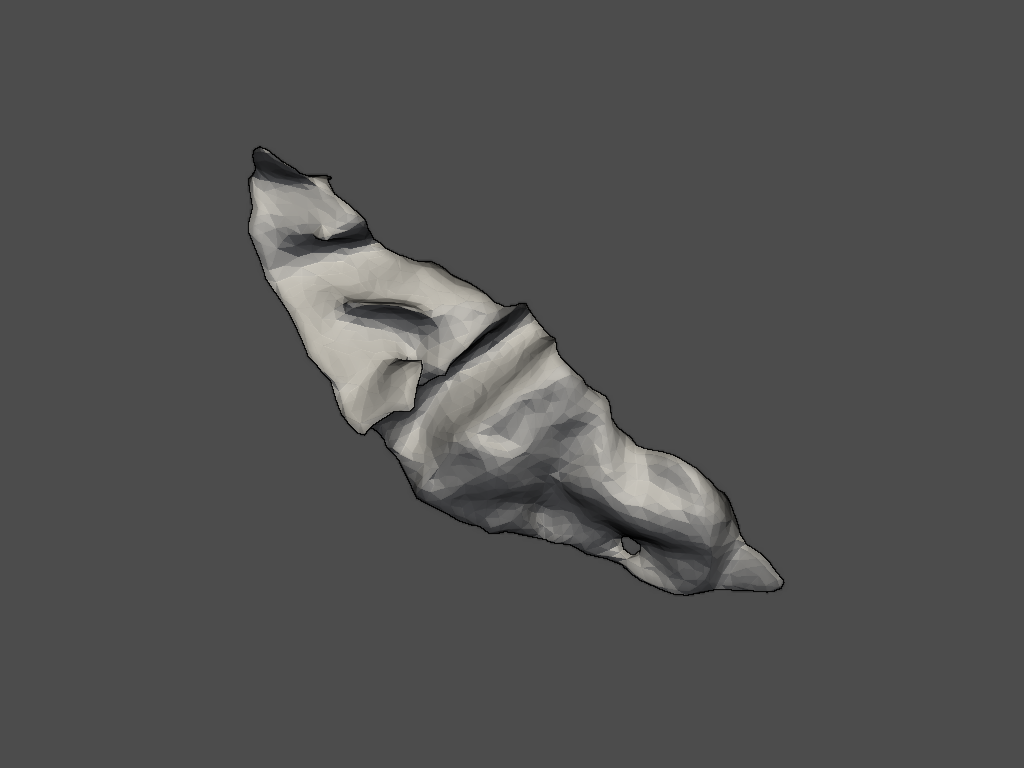

In [50]:

# Render the mesh and outline the holes
plotter = pv.Plotter()
plotter.add_mesh(orig_mesh, color=True)
plotter.enable_eye_dome_lighting()  # helps depth perception
_ = plotter.show(interactive=True,
                 cpos=(0.5, 1, 0.5),)

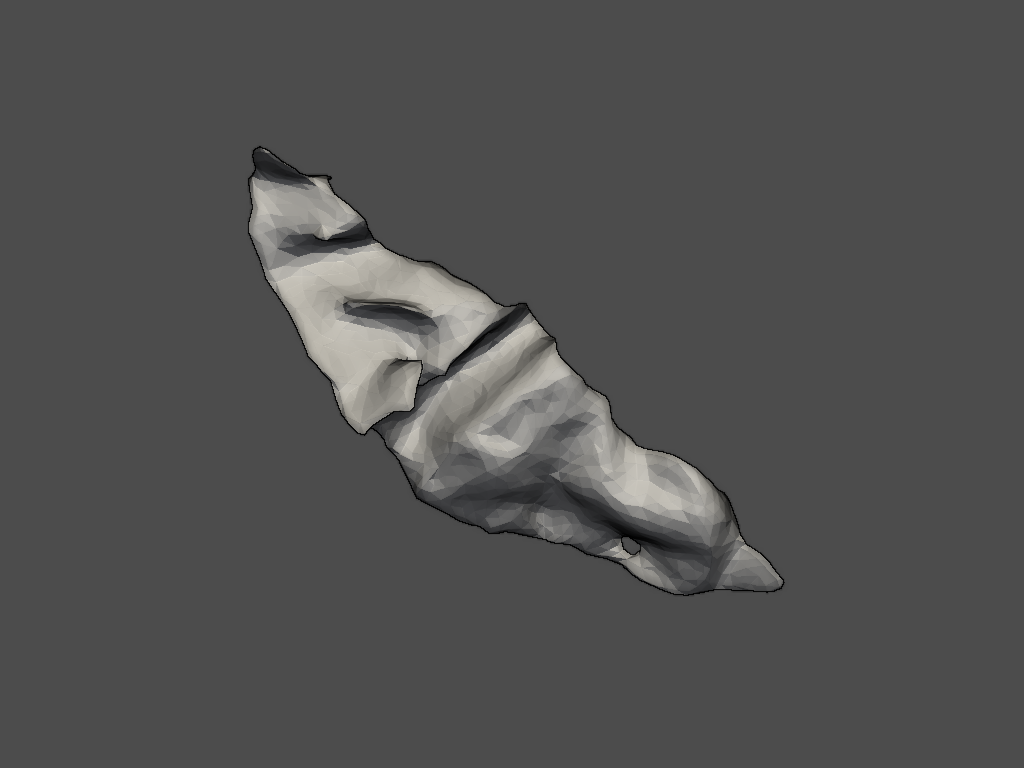

In [55]:
mfix = PyTMesh(False)  # False removes extra verbose output
mfix.load_file(p)

# Fills all the holes having at at most 'nbe' boundary edges. If
# 'refine' is true, adds inner vertices to reproduce the sampling
# density of the surroundings. Returns number of holes patched.  If
# 'nbe' is 0 (default), all the holes are patched.
mfix.fill_small_boundaries(nbe=0, refine=True)

###############################################################################
# Convert back to a pyvista mesh
vert, faces = mfix.return_arrays()
triangles = np.empty((faces.shape[0], 4), dtype=faces.dtype)
triangles[:, -3:] = faces
triangles[:, 0] = 3

mesh = pv.PolyData(vert, triangles)

################################################################################
# Plot the repaired mesh along with the original holes
# Note: It seems there is a limit to the repair algorithm whereby some
# of the holes that include only a single point are not filled. These
# boundary holes are not detected by VTK's hole repair algorithm
# either.

plotter = pv.Plotter()
plotter.add_mesh(mesh, color=True)
plotter.enable_eye_dome_lighting()  # helps depth perception
_ = plotter.show(interactive=True,
                 cpos=(0.5, 1, 0.5),)

In [56]:
from skimage.measure import label

In [97]:
res = label(corrected==0, connectivity=2)
np.unique(res, return_counts=True)

(array([0, 1], dtype=int32), array([    3708, 15921540]))

In [96]:
res = label(bvisa==0, connectivity=2)
np.unique(res, return_counts=True)

(array([0, 1], dtype=int32), array([    3928, 15921320]))

In [88]:
np.unique(res, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32),
 array([15921320,     1962,     1867,       37,       62]))

In [81]:
np.unique(res, return_counts=True)

(array([0, 1, 2, 3], dtype=int32),
 array([15921460,     1930,        1,     1857]))

In [77]:
np.unique(res, return_counts=True)

(array([0, 1], dtype=int32), array([    3708, 15921540]))

In [73]:
np.unique(res, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32),
 array([15921320,     1962,     1867,       37,       62]))

In [98]:
import pymeshlab
ms = pymeshlab.MeshSet()

In [99]:
ms.load_new_mesh(p)


In [109]:
ms.meshing_close_holes(maxholesize=1000000000,
                       selected=True,)

{'closed_holes': 0, 'new_faces': 0}